In [747]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import glob as gb
import cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import VGG16,ResNet50,DenseNet121,InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout, GlobalAveragePooling2D , Flatten,BatchNormalization
from tensorflow.keras.metrics import AUC, Recall, Precision, SpecificityAtSensitivity, SensitivityAtSpecificity, FalseNegatives, FalsePositives, TrueNegatives, TruePositives,F1Score
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

In [748]:
path='/kaggle/input/plant-d1/D1/'
for folder in  os.listdir(path +'train') : 
    files = gb.glob(pathname= str( path +'train//' + folder + '/*.jpg'))
    print(f'For train data , found {len(files)} in folder {folder}')

For train data , found 52 in folder Class (7)
For train data , found 52 in folder Class (37)


In [749]:
for folder in  os.listdir(path +'test') : 
    files = gb.glob(pathname= str( path +'test//' + folder + '/*.jpg'))
    print(f'For test data , found {len(files)} in folder {folder}')

For test data , found 12 in folder Class (7)
For test data , found 12 in folder Class (37)


In [750]:
#most repeated size in train file
size=[]
for i in os.listdir(path+'train'):
    files=gb.glob(pathname=str(path+'train//'+i+'/*.jpg'))
    for j in files:
        image=cv2.imread(j)
        size.append(image.shape)
pd.Series(size).value_counts()
###############################################

(256, 256, 3)    104
Name: count, dtype: int64

In [751]:
#most repeated size in test file
size=[]
for i in os.listdir(path+'test'):
    files=gb.glob(pathname=str(path+'test//'+i+'/*.jpg'))
    for j in files:
        image=cv2.imread(j)
        size.append(image.shape)
pd.Series(size).value_counts()

(256, 256, 3)    24
Name: count, dtype: int64

In [752]:
# Create a mapping dictionary for class labels
class_mapping = {'Class (37)': 0, 'Class (7)': 1}  # Add more classes as needed
img_size=256

In [753]:
x_train = []  # To store resized images
y_train = []  # To store class labels
for folder in os.listdir(path + 'train'):
    class_label = folder  # Assuming folder names represent class labels
    files = gb.glob(pathname=str(path + 'train//' + folder + '/*.jpg'))
    
    for file in files:
        image = cv2.imread(file)
        resized_image = cv2.resize(image, (img_size, img_size))  # Set your desired width and height
        x_train.append(resized_image)
        y_train.append(class_mapping[class_label])

# Convert the lists to NumPy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

# Now, x_train contains the resized images, and y_train contains the corresponding numerical class labels (0 and 1)
print(x_train.shape)
print(y_train.shape)

(104, 256, 256, 3)
(104,)


In [754]:
x_test = []  # To store resized images
y_test = []  # To store class labels
for folder in os.listdir(path + 'test'):
    class_label = folder  # Assuming folder names represent class labels
    files = gb.glob(pathname=str(path + 'test//' + folder + '/*.jpg'))
    
    for file in files:
        image = cv2.imread(file)
        resized_image = cv2.resize(image, (img_size, img_size))  # Set your desired width and height
        x_test.append(resized_image)
        y_test.append(class_mapping[class_label])

# Convert the lists to NumPy arrays
x_test = np.array(x_test)
y_test = np.array(y_test)

# Now, x_train contains the resized images, and y_train contains the corresponding numerical class labels (0 and 1)
print(x_test.shape)
print(y_test.shape)

(24, 256, 256, 3)
(24,)


In [ ]:
augmented_images = []
augmented_labels = []

for i in range(len(x_train)):
    img = x_train[i]

    # Append original image
    augmented_images.append(img)
    augmented_labels.append(y_train[i])

    # Apply vertical flip
    img_vertical_flip = cv2.flip(img, 0)
    augmented_images.append(img_vertical_flip)
    augmented_labels.append(y_train[i])

    # Apply horizontal flip
    img_horizontal_flip = cv2.flip(img, 1)
    augmented_images.append(img_horizontal_flip)
    augmented_labels.append(y_train[i])

    # Apply mirror transformation
    img_mirror = cv2.flip(img, -1)
    augmented_images.append(img_mirror)
    augmented_labels.append(y_train[i])

# Convert the augmented images and labels to NumPy arrays
x_train = np.array(augmented_images)
y_train = np.array(augmented_labels)

# Print the shapes to verify
print(x_train.shape)
print(y_train.shape)


(416, 256, 256, 3)
(416,)


In [ ]:

# Applying data augmentation to x_test
augmented_images_test = []
augmented_labels_test = []

for i in range(len(x_test)):
    img = x_test[i]

    # Append original image
    augmented_images_test.append(img)
    augmented_labels_test.append(y_test[i])

    # Apply vertical flip
    img_vertical_flip = cv2.flip(img, 0)
    augmented_images_test.append(img_vertical_flip)
    augmented_labels_test.append(y_test[i])

    # Apply horizontal flip
    img_horizontal_flip = cv2.flip(img, 1)
    augmented_images_test.append(img_horizontal_flip)
    augmented_labels_test.append(y_test[i])

    # Apply mirror transformation
    img_mirror = cv2.flip(img, -1)
    augmented_images_test.append(img_mirror)
    augmented_labels_test.append(y_test[i])

# Convert the augmented test images and labels to NumPy arrays
x_test = np.array(augmented_images_test)
y_test = np.array(augmented_labels_test)

# Print the shapes to verify
print(x_test.shape)
print(y_test.shape)


(96, 256, 256, 3)
(96,)


In [ ]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=42)
print(x_valid.shape)
print(y_valid.shape)

(84, 256, 256, 3)
(84,)


In [ ]:
x_train=x_train/255
x_test=x_test/255
x_valid=x_valid/255

In [ ]:
# Create a resnet50 model with pre-trained weights on ImageNet
pretrained_model_resnet50 = ResNet50(include_top=False,
                        input_shape=(img_size, img_size, 3),
                        pooling='avg',
                        weights='imagenet')

# Freeze the layers of the pre-trained model
for layer in pretrained_model_resnet50.layers:
    layer.trainable = False

# Create a Sequential model
resnet50_model = Sequential()

# Add the resnet50 pre-trained model to your Sequential model
resnet50_model.add(pretrained_model_resnet50)

# Flatten layer
resnet50_model.add(Flatten())

# Dense layers
resnet50_model.add(Dense(16, activation='relu'))
resnet50_model.add(Dense(1, activation='sigmoid'))

# Display model summary
print("resnet50 Model Summary:")
resnet50_model.summary()

resnet50 Model Summary:
Model: "sequential_100"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_96 (Flatten)        (None, 2048)              0         
                                                                 
 dense_217 (Dense)           (None, 16)                32784     
                                                                 
 dense_218 (Dense)           (None, 1)                 17        
                                                                 
Total params: 23620513 (90.11 MB)
Trainable params: 32801 (128.13 KB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


Epoch 1/100
21/21 [==============================] - 7s 140ms/step - loss: 0.7600 - accuracy: 0.4608 - auc_192: 0.4962 - recall_192: 0.4398 - precision_192: 0.4591 - specificity_at_sensitivity_192: 0.4458 - sensitivity_at_specificity_192: 0.4398 - false_negatives_192: 93.0000 - false_positives_192: 86.0000 - true_negatives_192: 80.0000 - true_positives_192: 73.0000 - val_loss: 0.6903 - val_accuracy: 0.5000 - val_auc_192: 0.7755 - val_recall_192: 0.0000e+00 - val_precision_192: 0.0000e+00 - val_specificity_at_sensitivity_192: 0.7143 - val_sensitivity_at_specificity_192: 0.8095 - val_false_negatives_192: 42.0000 - val_false_positives_192: 0.0000e+00 - val_true_negatives_192: 42.0000 - val_true_positives_192: 0.0000e+00
Epoch 2/100
21/21 [==============================] - 1s 56ms/step - loss: 0.6871 - accuracy: 0.5633 - auc_192: 0.5869 - recall_192: 0.5783 - precision_192: 0.5614 - specificity_at_sensitivity_192: 0.6145 - sensitivity_at_specificity_192: 0.5964 - false_negatives_192: 70.00

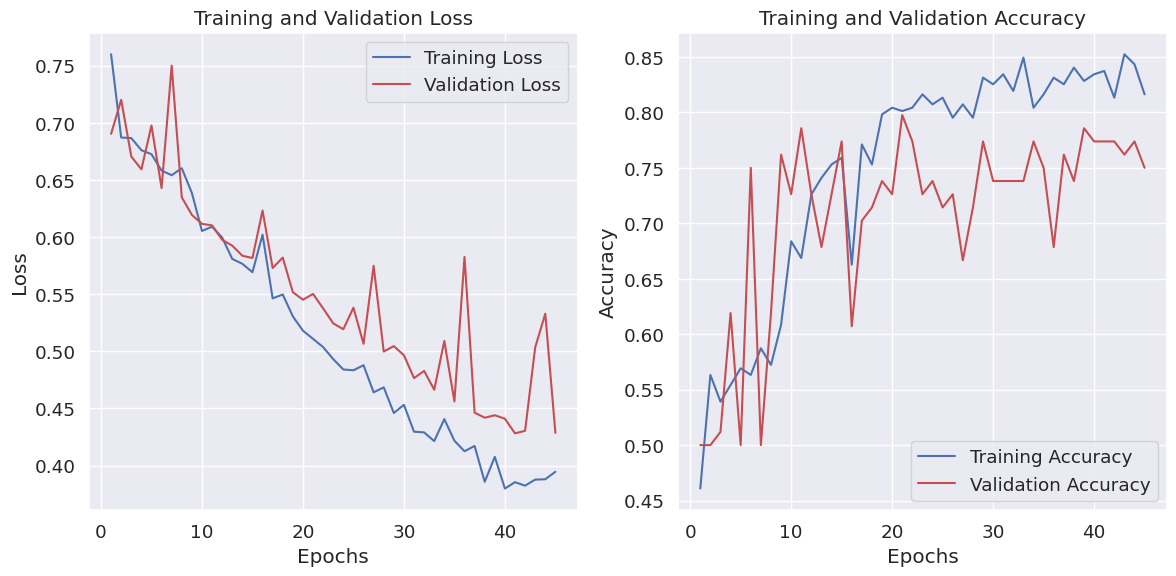

In [ ]:
# Calculate class weights
y_resnet50= y_train
class_weights_resnet50 = compute_class_weight('balanced', classes=np.unique(y_train), y=y_resnet50)

# Convert to dictionary
class_weight_dict_resnet50 = dict(enumerate(class_weights_resnet50))
#compile model
resnet50_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy',  
                             AUC(),
                             Recall(),
                             Precision(),
                             SpecificityAtSensitivity(0.5),
                             SensitivityAtSpecificity(0.5),
                             FalseNegatives(),
                             FalsePositives(),
                             TrueNegatives(),
                             TruePositives()])
#########################################
#train model
early_stopping = EarlyStopping(monitor='val_loss', patience=4, verbose=1)
resnet50_model.fit(x_train,y_train, batch_size=16,epochs = 100, validation_data = (x_valid,y_valid),class_weight=class_weight_dict_resnet50,callbacks=[early_stopping])
# Accessing training and validation history
training_loss = resnet50_model.history.history['loss']
validation_loss = resnet50_model.history.history['val_loss']
training_accuracy = resnet50_model.history.history['accuracy']
validation_accuracy = resnet50_model.history.history['val_accuracy']

# Plotting the training and validation loss
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, training_loss, 'b-', label='Training Loss')
plt.plot(epochs, validation_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, training_accuracy, 'b-', label='Training Accuracy')
plt.plot(epochs, validation_accuracy, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
results_resnet50 = resnet50_model.evaluate(x_test, y_test, verbose=1)

# This will print the evaluation results (loss, accuracy, and other metrics specified during model compilation)
print("Test Loss:", results_resnet50[0])
print("Test Accuracy:", results_resnet50[1])
# You can print other metrics based on your model's configuration

#test the model
predictions_resnet50 = resnet50_model.predict(x_test)

3/3 [==============================] - 0s 81ms/step - loss: 0.3557 - accuracy: 0.8854 - auc_192: 0.9759 - recall_192: 0.7708 - precision_192: 1.0000 - specificity_at_sensitivity_192: 1.0000 - sensitivity_at_specificity_192: 1.0000 - false_negatives_192: 11.0000 - false_positives_192: 0.0000e+00 - true_negatives_192: 48.0000 - true_positives_192: 37.0000     
Test Loss: 0.355663537979126
Test Accuracy: 0.8854166865348816
3/3 [==============================] - 1s 68ms/step


In [ ]:
y_pred_resnet50 = resnet50_model.predict(x_valid)
fpr, tpr, _ = roc_curve(y_valid, y_pred_resnet50)

# Calculate the area under the curve (AUC)
roc_auc_resnet50 = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc_resnet50))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve_resnet50')
plt.legend(loc='lower right')
plt.show()

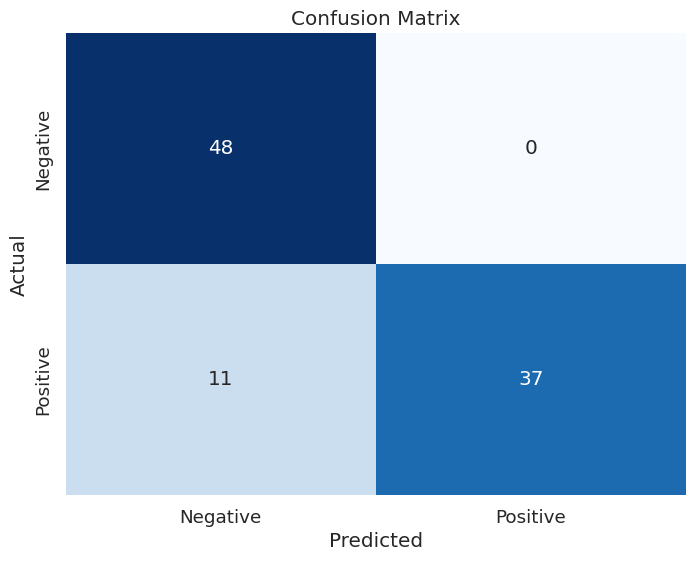

F1 Score: 0.8705882352941177
Classification Report:
              precision    recall  f1-score   support

           0       0.81      1.00      0.90        48
           1       1.00      0.77      0.87        48

    accuracy                           0.89        96
   macro avg       0.91      0.89      0.88        96
weighted avg       0.91      0.89      0.88        96



In [ ]:
# Convert probabilities to binary predictions (assuming a threshold of 0.5)
binary_predictions_resnet50 = (predictions_resnet50 > 0.5).astype(int)

# Create confusion matrix
conf_matrix = confusion_matrix(y_test, binary_predictions_resnet50)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font size for better readability
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Calculate F1 score
f1_resnet50 = f1_score(y_test, binary_predictions_resnet50)

# Print F1 score
print("F1 Score:", f1_resnet50)

# Print detailed classification report
print("Classification Report:")
print(classification_report(y_test, binary_predictions_resnet50))